In [113]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, BatchNormalization, Activation,Conv2DTranspose,MaxPooling2D
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.applications.vgg19 import VGG19
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [114]:
#defining hyper parameters! 
learning_rate= 0.001
epochs = 10
batch_size = 120
image_size= (224,224)
GLOROT_INITIALIZER = tf.keras.initializers.glorot_normal(seed=None)


In [115]:
#lets create a fW network first! 
#I hope my code makes more sense than my understanding! 
#create a sequential model! 
model = Sequential()
#first and last layer has 9*9 strides! 
#weight initializer

model.add(Conv2D(64,activation=None,strides=(1,1),kernel_size=(9,9),kernel_initializer=GLOROT_INITIALIZER,padding='same',input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())

# #shape = 64*112*112

model.add(Conv2D(128,activation=None,strides=(1,1),kernel_size=(3,3),kernel_initializer=GLOROT_INITIALIZER,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
#shape = 128*56*56


model.add(Conv2D(256,activation=None,strides=(1,1),kernel_size=(3,3),kernel_initializer=GLOROT_INITIALIZER,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D())
#shape = 256*28*28

model.add(Conv2DTranspose(256,activation=None,strides=(2,2),kernel_size=(3,3),kernel_initializer=GLOROT_INITIALIZER,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
#shape = 256*56*56

model.add(Conv2DTranspose(512,activation=None,strides=(2,2),kernel_size=(3,3),kernel_initializer=GLOROT_INITIALIZER,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
#shape = 512*112*112

model.add(Conv2DTranspose(3,activation=None,strides=(2,2),kernel_size=(9,9),kernel_initializer=GLOROT_INITIALIZER,padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

#shape = 3*224*224
#input is transformed babay! 

In [116]:
# next we define the keras VGG19 network for the loss
base_model = VGG19(weights='imagenet')


In [117]:
loss_model = tf.keras.models.Sequential()
for eachLayer in base_model.layers[:12]:
    eachLayer.trainable=False
loss_model.add(eachLayer)

def meanSquaredLoss(y_true,y_pred):
    theLoss = tf.reduce_mean(tf.keras.losses.MSE(y_true,y_pred))    
    return theLoss

def featureLoss(image):
    predicted_image = model(image)
    activatedModelVal = loss_model(predicted_image,training=False)
    actualModelVal = loss_model(image,training=False)
    return meanSquaredLoss(actualModelVal,activatedModelVal)

In [118]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

def styleLoss(image):
    predicted_image = model(image)
    plt.imshow(tf.cast(predicted_image,tf.int64)[0])
    activatedModelVal = loss_model(predicted_image,training=False)
    actualModelVal = loss_model(image,training=False)
    return meanSquaredLoss(gram_matrix(actualModelVal),gram_matrix(activatedModelVal))
        

In [119]:
STORE_LOCATION_SINGLE_DATA='D:/trainableDataset/data1.npy'
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [120]:
images= np.load(STORE_LOCATION_SINGLE_DATA)
class CustomDataGenerator():
    def __init__(self,images,batch_size=10,scaling=True,shuffle =True):
        self.images = images
        self.batch_size = batch_size
        self.scaling = scaling
        self.shuffle=shuffle
        if scaling:
            self.scaleData()
    def getData(self):
        if self.shuffle:
            np.random.shuffle(images)
        k=0
        while True:
            if(k>len(self.images)):
                break   
            batch_xs = self.images[k:k+self.batch_size]
            k=k+batch_size
            yield tf.convert_to_tensor(batch_xs,dtype=tf.float32)
    def scaleData(self):
        pass
        #nothing for now! 
        
            

In [121]:

images= images/255.0


In [122]:
dataGen = CustomDataGenerator(images)


In [123]:
opt = tf.keras.optimizers.Adam(0.001)
    
theImagesFromModel = []
def each_train_step(image,epochNumber,testImage,model=model):
    with tf.GradientTape() as tape:
        styleLossVal = styleLoss(image) 
        featureLossVal = featureLoss(image)
        loss = styleLossVal + featureLossVal
        grad = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(grad, model.trainable_variables))
        model.save_weights('./checkpoints/my_checkpoint{}.ckpt'.format(epochNumber))
        print("Epoch Number =>{} loss= {}".format(epochNumber,loss))
        theImagesFromModel.append(model(testImage)[0])

Epoch Number =>0 loss= 0.4391547441482544
Epoch Number =>0 loss= 0.2168300598859787
Epoch Number =>0 loss= 5.353109359741211
Epoch Number =>0 loss= 0.14422696828842163
Epoch Number =>0 loss= 0.44838571548461914
Epoch Number =>0 loss= 0.3859727382659912
Epoch Number =>0 loss= 0.3686065673828125
Epoch Number =>0 loss= 0.4618452787399292
Epoch Number =>0 loss= 0.3674243688583374
Epoch Number =>1 loss= 0.32170069217681885
Epoch Number =>1 loss= 0.3599569797515869
Epoch Number =>1 loss= 0.38382118940353394
Epoch Number =>1 loss= 0.5366235375404358
Epoch Number =>1 loss= 0.40033072233200073
Epoch Number =>1 loss= 0.33631980419158936
Epoch Number =>1 loss= 0.4761815667152405
Epoch Number =>1 loss= 0.3026410937309265
Epoch Number =>1 loss= 0.17271265387535095
Epoch Number =>2 loss= 0.034027550369501114
Epoch Number =>2 loss= 0.7088109254837036
Epoch Number =>2 loss= 0.0401751771569252
Epoch Number =>2 loss= 0.09114900976419449
Epoch Number =>2 loss= 0.12830084562301636
Epoch Number =>2 loss= 0

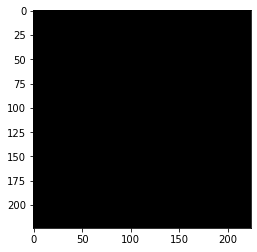

In [124]:
FILENAME='bhanu.jpg'
im = Image.open(FILENAME)
im.thumbnail((224,224), Image.ANTIALIAS)
bhanu = np.array(im)

bhanu2Show = bhanu.reshape((1,224,224,3))
x = tf.convert_to_tensor(bhanu2Show, np.float32)


# with tf.GradientTape() as tape:
#     styleLossVal = styleLoss(x) 
#     featureLossVal = featureLoss(x)
#     print('THE STYLE LOSS {} THE FEATURE LOSS {} '.format(styleLossVal,featureLossVal))
# # each_train_step(x,i,x)

for i in range(epochs):
    for eachData in  dataGen.getData(): 
        each_train_step(eachData,i,x)

In [ ]:
FILENAME='bhanu.jpg'
im = Image.open(FILENAME)
im.thumbnail((224,224), Image.ANTIALIAS)
bhanu = np.array(im)

bhanu2Show = bhanu.reshape((1,224,224,3))
x = tf.convert_to_tensor(bhanu2Show, np.float32)

newX = tf.cast(model(x),tf.int64)
plt.imshow(newX[0])

In [60]:
# #dataset preparation! 
# from PIL import Image
# import numpy as np
# import os.path


# LOCATION = 'D:/test2014'
# STORE_LOCATION='D:/trainableDataset'

# length = 224 # pixels in length
# width = 224 # pixels in width
# noOfMaxImage = 1000

# images = []
# number=1

# for filename in os.listdir(LOCATION):
#     if filename.endswith(".jpg"):
#         img = Image.open(os.path.join(LOCATION,filename)).convert('RGB')
#         img = img.resize((length,width), Image.ANTIALIAS)
#         images.append(np.array(img))
#         if(len(images)%noOfMaxImage==0):
#             np.save('{}/data{}.npy'.format(STORE_LOCATION,number), images)
#             number = number+1
#             images = []
            

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


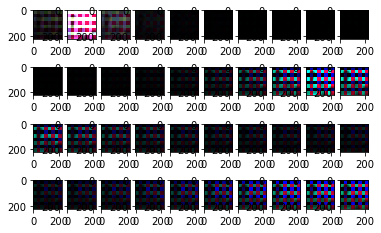

In [131]:
for index,eachImage in enumerate(theImagesFromModel):
    if(index==40):
        break
    plt.subplot(4,10,index+1)
    plt.imshow(tf.cast(eachImage,tf.int64))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


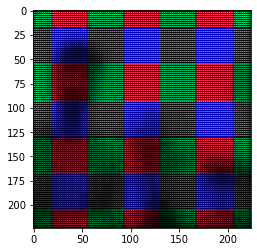

In [134]:
plt.imshow(tf.cast(model(x)[0],tf.int64))

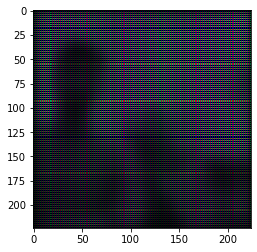

In [195]:
plt.imshow(tf.cast(theImagesFromModel[55],tf.int64))